In [2]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

import meshio
msh = meshio.read(r"fem-data/plate_hole.msh")
for cell in msh.cells:
    triangle_cells = cell.data

triangle_mesh = meshio.Mesh(points=msh.points[:, :2], cells={"triangle": triangle_cells})
meshio.write(r"fem-data/plate_hole.xdmf", triangle_mesh, file_format='xdmf')


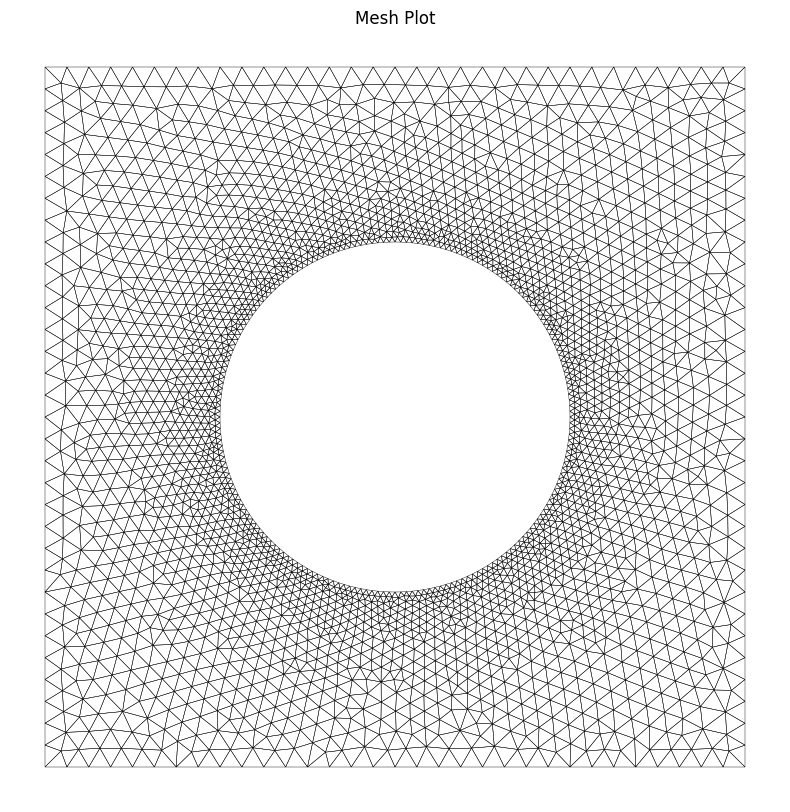

Mesh dimension: 2


In [3]:
# Load the mesh
mesh = Mesh()
with XDMFFile(r"fem-data/plate_hole.xdmf") as infile:
    infile.read(mesh)

# Extract vertices and cells from the mesh
vertices = mesh.coordinates()
cells = mesh.cells()

# Plot the mesh
plt.figure(figsize=(10, 10))
for cell in cells:
    vertices_cell = vertices[cell]
    plt.fill(vertices_cell[:, 0], vertices_cell[:, 1], edgecolor='k', linewidth=0.3, fill=False)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Mesh Plot')
plt.gca().set_aspect('equal')
plt.gca().axis('off')
plt.show()

print("Mesh dimension:", mesh.geometric_dimension())

In [4]:


# Define geometry parameters
Lmax = 2.0
Hmax = 2.0
n_mesh = 30

pstress = 1.0

E =210e3 # 210GPa
nu = 0.3
lambda_ = E*nu/((1+nu)*(1-2*nu))
mu = E/(2*(1+nu))

# Create the geometry with notches
plate_length = Lmax
plate_height = Hmax

# Define boundary condition
V = VectorFunctionSpace(mesh, 'P', 1)

tol = 1E-14

def top_boundary(x, on_boundary):
    return on_boundary and near(x[1], plate_height, tol)

def bottom_boundary(x, on_boundary):
    return on_boundary and near(x[1], 0, tol)



bc1 = DirichletBC(V.sub(0), Constant(0), top_boundary)
bc2 = DirichletBC(V.sub(1), Constant(0), bottom_boundary)
bc3 = DirichletBC(V.sub(0), Constant(0), bottom_boundary)
bc = [bc1, bc2, bc3]

#mark right boundary
top = AutoSubDomain(top_boundary)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
top.mark(boundaries, 1)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# Define strain and stress

def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    # return sym(nabla_grad(u))

def sigma(u):
    return lambda_*div(u)*Identity(d) + 2*mu*epsilon(u)


# Define variational problem
x = SpatialCoordinate(mesh)
u = TrialFunction(V)
d = u.geometric_dimension()  # space dimension
v = TestFunction(V)
f = Constant((0, 0))

T = Constant((0, pstress))
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(T, v)*ds(1)

# Compute solution
u = Function(V)
solve(a == L, u, bc)

tensor_space = TensorFunctionSpace(mesh, 'P', 1)
strain = project(epsilon(u), tensor_space)
stress = project(sigma(u), tensor_space)


Solving linear variational problem.


Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


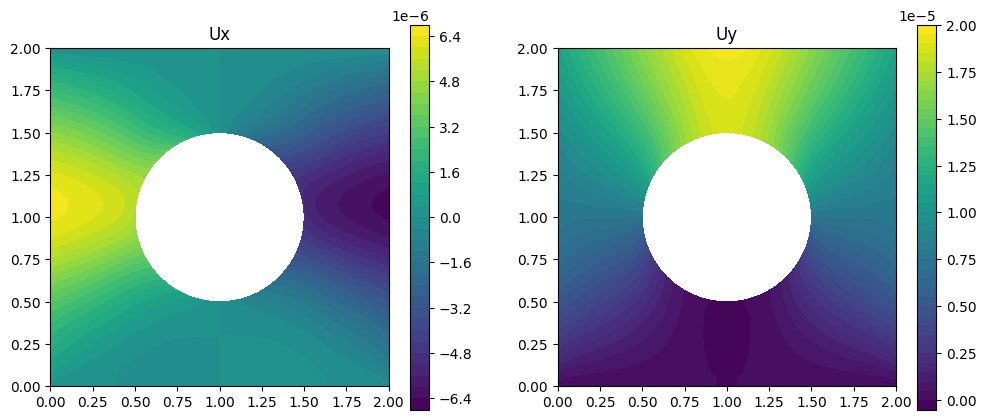

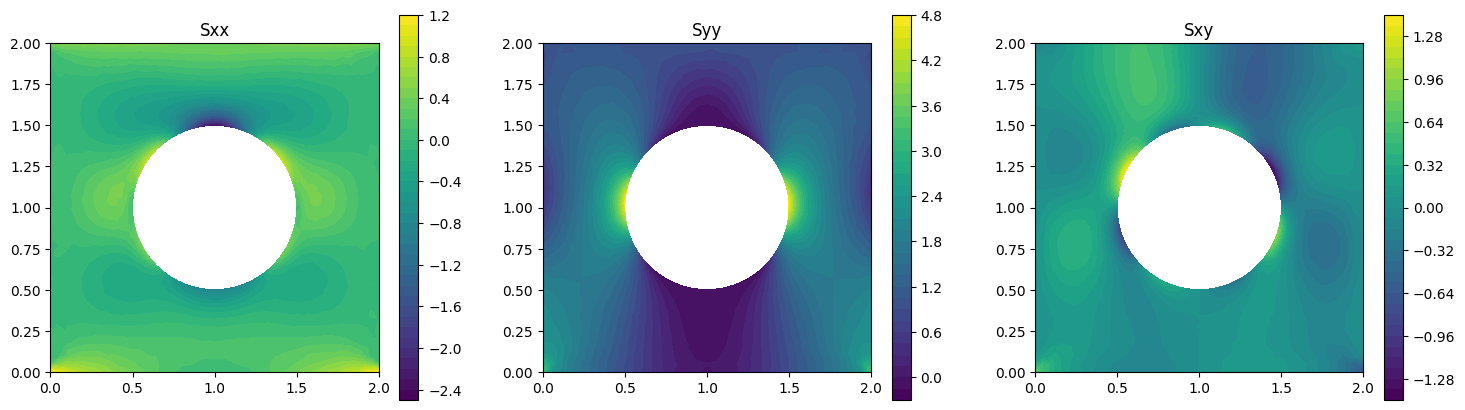

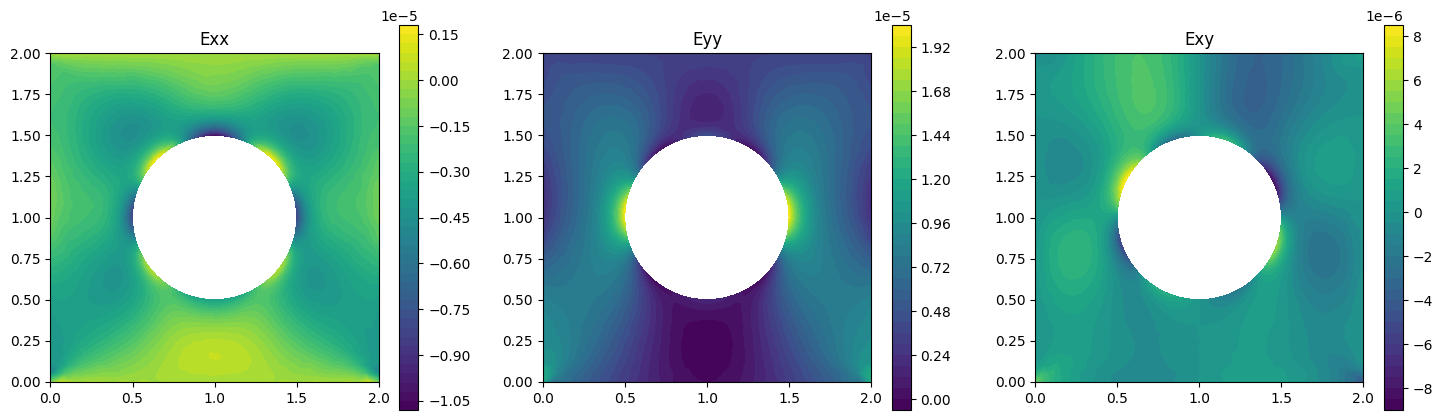

In [5]:
plt.subplots(1,2, figsize=(12, 5))

plt.subplot(121)
im = plot(u[0], mesh=mesh, title='Ux')
plt.colorbar(im)
plt.subplot(122)
im = plot(u[1], title='Uy')
plt.colorbar(im)

plt.subplots(1,3, figsize=(18, 5))
plt.subplot(131)
im = plot(stress[0, 0], title='Sxx')
plt.colorbar(im)
plt.subplot(132)
im = plot(stress[1, 1], title='Syy')
plt.colorbar(im)
plt.subplot(133)
im = plot(stress[0, 1], title='Sxy')
plt.colorbar(im)

plt.subplots(1,3, figsize=(18, 5))
plt.subplot(131)
im = plot(strain[0, 0], title='Exx')
plt.colorbar(im)
plt.subplot(132)
im = plot(strain[1, 1], title='Eyy')
plt.colorbar(im)
plt.subplot(133)
im = plot(strain[0, 1], title='Exy')
plt.colorbar(im)

/tmp/ipykernel_856431/1965005448.py:34: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')


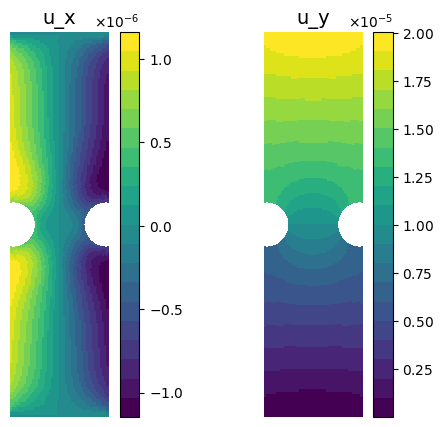

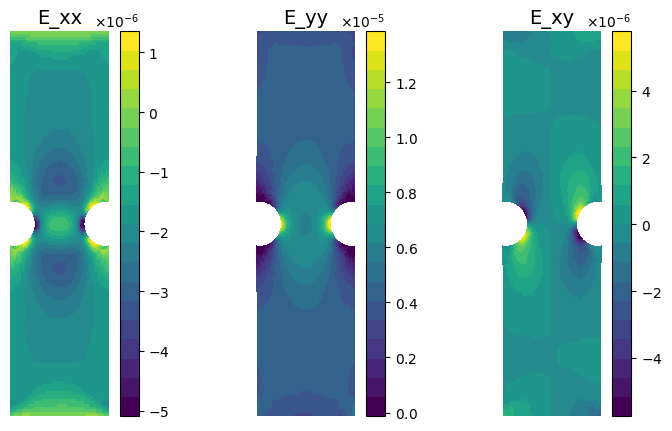

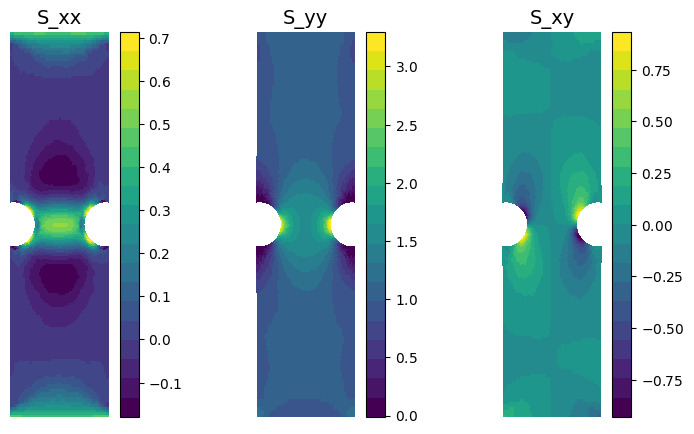

In [91]:
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# Load geometry mapping
from scipy.ndimage import map_coordinates
nx=25
ny=75
x_max = 1.0
y_max = 4.0

Xp = np.loadtxt(f"../geometry/deep_notched_{nx}x{ny}.txt")

# Interpolate mapping
X_map_points = Xp[:, 0].reshape((ny, nx)).T
Y_map_points = Xp[:, 1].reshape((ny, nx)).T

def geometry_mapping(x,y,padding=1e-6):
    x_pos = x/x_max*(nx-1)*(1-2*padding) + padding
    y_pos = y/y_max*(ny-1)*(1-2*padding) + padding

    x_mapped = map_coordinates(X_map_points, [x_pos, y_pos], order=1)
    y_mapped = map_coordinates(Y_map_points, [x_pos, y_pos], order=1)

    return x_mapped, y_mapped


def pcolor_plot(AX, X, Y, C, title,colormap="copper",set_axis = 'off',colorbar=True,**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.set_aspect("equal", "box")
    AX.axis(set_axis)
    AX.set_title(title, fontsize=14)
    fig.colorbar(im, ax=AX, format=formatter)
    return im

cmap = plt.get_cmap('viridis')
num_colors = 20
color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
cmap = ListedColormap(color_values)

n_mesh_x = 50
n_mesh_y = 200

x_plot = np.linspace(0, Lmax, n_mesh_x)
y_plot = np.linspace(0, Hmax, n_mesh_y)
X, Y = np.meshgrid(x_plot, y_plot)

X, Y = geometry_mapping(X, Y)

X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

u_val = np.array([u(X_grid[i, :]) for i in range(X_grid.shape[0])])
strain_val = np.array([strain(X_grid[i, :]) for i in range(X_grid.shape[0])])
strain_val = np.array([strain_val[:,0], strain_val[:,3], 0.5*(strain_val[:,1]+strain_val[:,2])]).T
stress_val = np.array([stress(X_grid[i, :]) for i in range(X_grid.shape[0])])
stress_val = np.array([stress_val[:,0], stress_val[:,3], 0.5*(stress_val[:,1]+stress_val[:,2])]).T

# # Plot displacement
fig, ax = plt.subplots(1, 2, figsize=(6, 5))
im = pcolor_plot(ax[0], X, Y, u_val[:,0].reshape(X.shape), "u_x",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, u_val[:,1].reshape(X.shape), "u_y",colormap=cmap)

# # Plot strain
fig, ax = plt.subplots(1, 3, figsize=(9, 5))
im = pcolor_plot(ax[0], X, Y, strain_val[:,0].reshape(X.shape), "E_xx",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, strain_val[:,1].reshape(X.shape), "E_yy",colormap=cmap)
im = pcolor_plot(ax[2], X, Y, strain_val[:,2].reshape(X.shape), "E_xy",colormap=cmap)

# Plot stress
fig, ax = plt.subplots(1, 3, figsize=(9, 5))
im = pcolor_plot(ax[0], X, Y, stress_val[:,0].reshape(X.shape), "S_xx",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, stress_val[:,1].reshape(X.shape), "S_yy",colormap=cmap)
im = pcolor_plot(ax[2], X, Y, stress_val[:,2].reshape(X.shape), "S_xy",colormap=cmap)

plt.show()


In [92]:
print(f"Ux_mean = {np.mean(u_val[:,0]):2e} ; Uy_mean = {np.mean(u_val[:,1]):2e}")
print(f"Exx_mean = {np.mean(strain_val[:,0]):2e} ; Eyy_mean = {np.mean(strain_val[:,1]):2e} ; Exy_mean = {np.mean(strain_val[:,2]):2e}")
print(f"Sxx_mean = {np.mean(stress_val[:,0]):2e} ; Syy_mean = {np.mean(stress_val[:,1]):2e} ; Sxy_mean = {np.mean(stress_val[:,2]):2e}")

Ux_mean = 5.006620e-09 ; Uy_mean = 9.942707e-06
Exx_mean = -1.862893e-06 ; Eyy_mean = 4.924018e-06 ; Exy_mean = -1.983530e-10
Sxx_mean = 6.993813e-02 ; Syy_mean = 1.166285e+00 ; Sxy_mean = -3.204164e-05


In [93]:
# Save solution 
np.savetxt(f"fem_solution_{n_mesh_x}x{n_mesh_y}.dat", np.hstack((X_grid, u_val, strain_val, stress_val)), delimiter=' ')

In [100]:
from scipy.interpolate import RegularGridInterpolator

# Load solution
data = np.loadtxt("fem_solution_50x200.dat")
X_val = data[:, :2]
u_val = data[:, 2:4]
stress_val = data[:, 7:10]

solution_val = np.hstack((u_val, stress_val))

# Interpolate solution
x_grid = np.linspace(0, x_max, n_mesh_x)
y_grid = np.linspace(0, y_max, n_mesh_y)

interpolators = []
for i in range(solution_val.shape[1]):
    interp = RegularGridInterpolator((x_grid, y_grid), solution_val[:, i].reshape(n_mesh_y, n_mesh_x).T)
    interpolators.append(interp)

solution_fn = lambda x, y: np.array([interp((x, y)) for interp in interpolators]).T

/tmp/ipykernel_856431/1965005448.py:34: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')


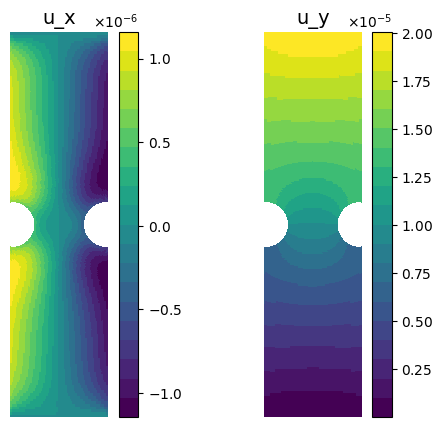

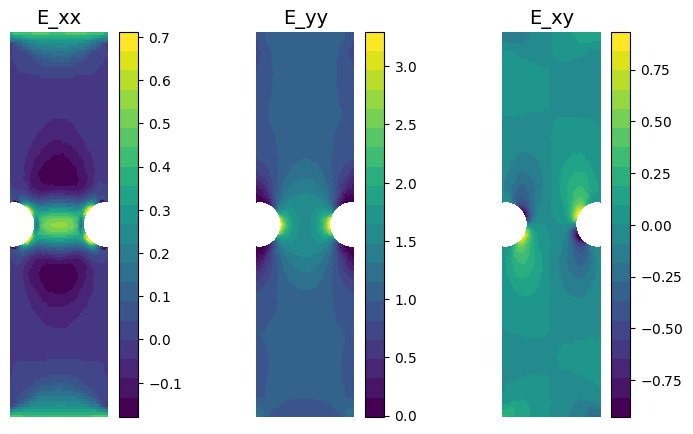

In [104]:
# Check interpolation
x_plot = np.linspace(0, Lmax, n_mesh_x+17)
y_plot = np.linspace(0, Hmax, n_mesh_y-9)
X, Y = np.meshgrid(x_plot, y_plot)
X_mapped, Y_mapped = geometry_mapping(X, Y)

X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

solution_plot = solution_fn(X_grid[:, 0], X_grid[:, 1])

fig, ax = plt.subplots(1, 2, figsize=(6, 5))
im = pcolor_plot(ax[0], X_mapped, Y_mapped, solution_plot[:,0].reshape(X.shape), "u_x",colormap=cmap)
im = pcolor_plot(ax[1], X_mapped, Y_mapped, solution_plot[:,1].reshape(X.shape), "u_y",colormap=cmap)

fig, ax = plt.subplots(1, 3, figsize=(9, 5))
im = pcolor_plot(ax[0], X_mapped, Y_mapped, solution_plot[:,2].reshape(X.shape), "E_xx",colormap=cmap)
im = pcolor_plot(ax[1], X_mapped, Y_mapped, solution_plot[:,3].reshape(X.shape), "E_yy",colormap=cmap)
im = pcolor_plot(ax[2], X_mapped, Y_mapped, solution_plot[:,4].reshape(X.shape), "E_xy",colormap=cmap)
